# SRC and HCK Interaction Analysis Pipeline

### 1. Library Imports and Setup

In [1]:
import sys
sys.path.append('./')  # Add current directory to the Python path
sys.path.append('./lib')  # Add 'lib' subdirectory

from calcul import (
    calculate_Kapp,
    get_bait_concentration,
    calculate_complexome,
    log_scale
)

from file_op import (
    extract_species_bait,
    read_csv_file,
    save_csv_file,
    merge_files,
    group_columns_by_species
)

from comparison import (
    calculate_deltapKapp,
    calculate_complexome_difference,
    log_delta,
    calculate_intraspecies_log_complexome_ratio
)

from Venn_diag import (plot_venn_diagram)

from complexome_plot import (plot_complexome_analysis)

from lin_reg import (analyze_and_plot_correlation)

### 2. Data loading and complexome analysis for each bait

In [ ]:
# Human SRC
filepath = "input/human_src_data.csv"
output_path = "output/human_src_data.csv"
df_raw= read_csv_file(filepath, header=0)
species, bait = extract_species_bait(filepath)
print(f"Species : {species} , Bait: {bait}")
bait_conc = get_bait_concentration(df_raw, filepath)
df = calculate_Kapp(df_raw)
df = calculate_complexome(df,filepath)
df = log_scale(df)
save_csv_file(df, output_path)

# Human HCK
filepath = "input/human_hck_data.csv"
output_path = "output/human_hck_data.csv"
df_raw= read_csv_file(filepath, header=0)
species, bait = extract_species_bait(filepath)
print(f"Species : {species} , Bait: {bait}")
bait_conc = get_bait_concentration(df_raw, filepath)
df = calculate_Kapp(df_raw)
df = calculate_complexome(df,filepath)
df = log_scale(df)
save_csv_file(df, output_path)

# Mouse SRC
filepath = "input/mouse_src_data.csv"
output_path = "output/mouse_src_data.csv"
df_raw= read_csv_file(filepath, header=0)
species, bait = extract_species_bait(filepath)
print(f"Species : {species} , Bait: {bait}")
bait_conc = get_bait_concentration(df_raw, filepath)
df = calculate_Kapp(df_raw)
df = calculate_complexome(df,filepath)
df = log_scale(df)
save_csv_file(df, output_path)

# Mouse HCK
filepath = "input/mouse_hck_data.csv"
output_path = "output/mouse_hck_data.csv"
df_raw= read_csv_file(filepath, header=0)
species, bait = extract_species_bait(filepath)
print(f"Species : {species} , Bait: {bait}")
bait_conc = get_bait_concentration(df_raw, filepath)
df = calculate_Kapp(df_raw)
df = calculate_complexome(df,filepath)
df = log_scale(df)
save_csv_file(df, output_path)

### 3. Merge dataframe for comparative analysis

In [ ]:
file_list = ["output/human_src_data.csv", "output/human_hck_data.csv", "output/mouse_src_data.csv", "output/mouse_hck_data.csv"]  # adjust paths if needed
output_path = "output/merged.csv"

df_merged = merge_files(file_list, output_path)
df = calculate_deltapKapp(df_merged)
df = calculate_complexome_difference(df)
df = log_delta(df)
df = calculate_intraspecies_log_complexome_ratio(df)
df= group_columns_by_species(df)
save_csv_file(df, output_path)



### 4. Visualize the data

##### 
- Venn diagrams : Number of significant binding partners.

In [ ]:
df_path = "output/merged.csv"
df = read_csv_file(df_path, header=[0, 1, 2])
output= "output/venn_diagrams"

df = plot_venn_diagram(df, output)

##### 
- Plots showing the evolution of complexe formation depending on affinity and availability of binding partners.

In [ ]:
# Plots showing the evolution of complexe formation # Load the DataFrame properly
df_path = "output/merged.csv"
df = read_csv_file(df_path, header=[0, 1, 2])  # MultiIndex columns expected

# Define output directory
output = "output/complexome_analysis"

# Now call the function
plot_complexome_analysis(df, output)

# REPRENDRE ICI

##### 
- Linear Regrassion Plots for comparative analysis

File output/merged.csv loaded successfully.


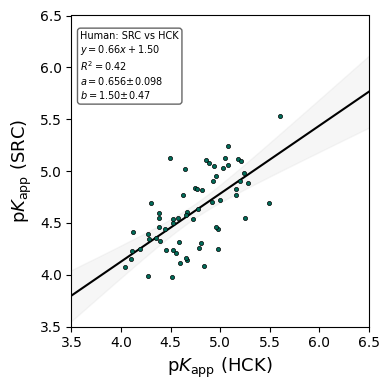

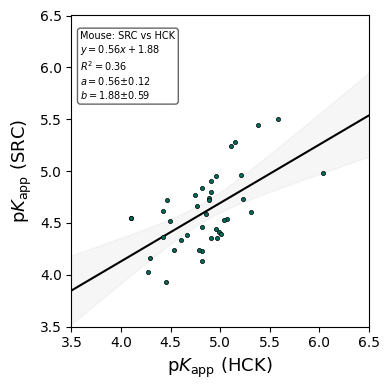

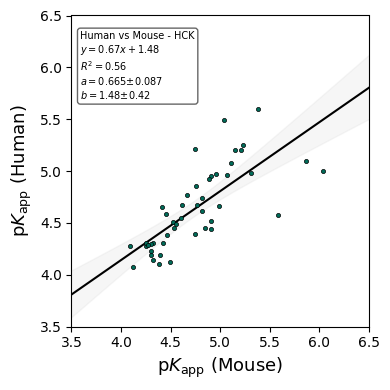

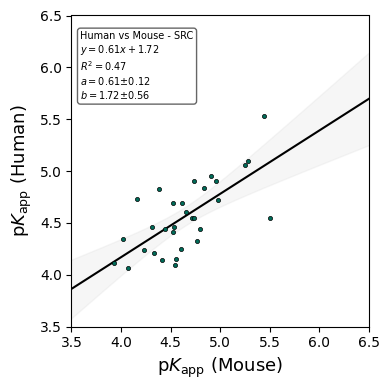

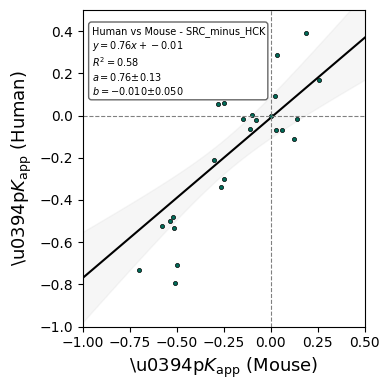

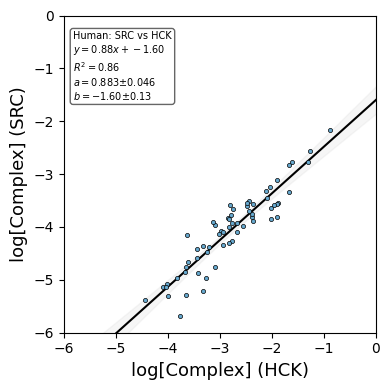

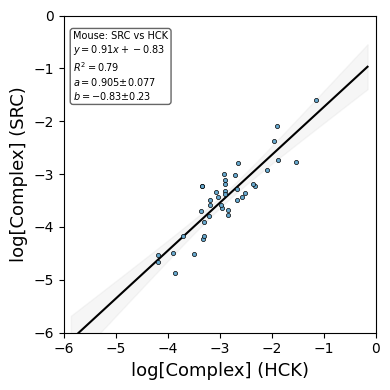

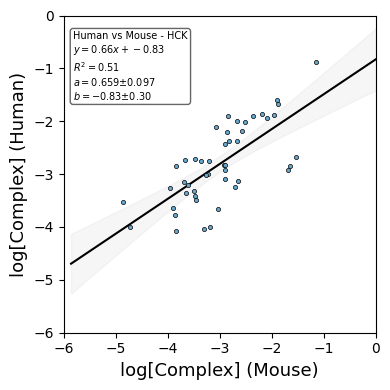

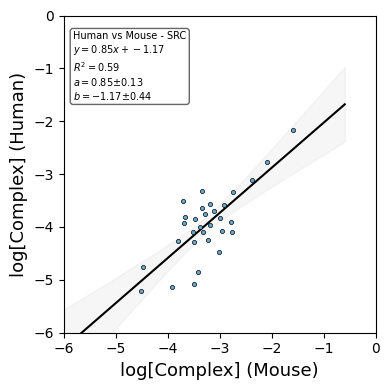

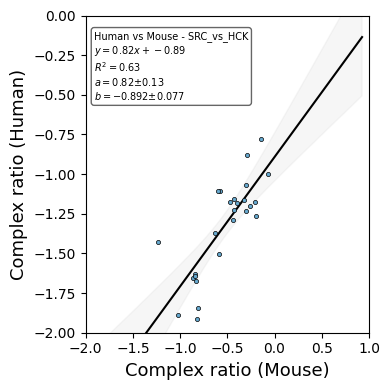

✅ All plots generated and saved successfully.


In [ ]:
df_path = "output/merged.csv"
df = read_csv_file(df_path, header=[0, 1, 2])  

# Define output directory
output = "output/Linear_regression"

df = analyze_and_plot_correlation(df, annotate_genes=False)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.optimize import curve_fit
from scipy import stats
import uncertainties.unumpy as unp
import uncertainties as unc

def analyze_and_plot_correlation(df, output_dir="output/Lin_Reg_Plots", target_metrics=("pKapp", "delta_pKapp", "log_complexome", "ratio_log_complexome"), annotate_genes=False):
    """
    Automatically generates pairwise linear regression plots between species
    for both inter-species and intra-species comparisons across all baits and selected metrics.

    Parameters:
        df (pd.DataFrame): DataFrame with MultiIndex columns (species, bait, metric)
        output_dir (str): Directory to save output plots
        target_metrics (tuple): Metrics to analyze (e.g., 'pKapp', 'log_complexome')
        annotate_genes (bool): If True, annotate points using gene_id column (if available)

    Output:
        Saves and displays one plot per metric/bait/species pair in the specified output folder.

    """
    os.makedirs(output_dir, exist_ok=True)

    # Identifier espèces et baits
    species_list = sorted({col[0] for col in df.columns if len(col) == 3})
    bait_list = sorted({col[1] for col in df.columns if len(col) == 3})
    target_metrics = list(target_metrics)

    color_map ={
        'pKapp': '#016c59',
        'delta_pKapp': '#016c59',
        'log_complexome': '#67a9cf',
        'ratio_log_complexome': '#67a9cf'
    }

    label_map = {
        'pKapp': (r'p$\it{K}_{\rm app}$', [3.5, 6.5], [3.5, 6.5]),
        'delta_pKapp': (r'Δp$\it{K}_{\rm app}$', [-1.0, 0.5], [-1.0, 0.5]),
        'log_complexome': ('log[Complex]', [-6, 0], [-6, 0]),
        'ratio_log_complexome': ('Complex ratio', [-2, 1], [-2, 0])
    }


    ordered_metrics = [m for m in target_metrics if 'pKapp' in m] + \
                      [m for m in target_metrics if 'complexome' in m]

# Intra-species bait comparisons
    for metric in ordered_metrics:
        for species in species_list:
            valid_baits = [bait for bait in bait_list if (species, bait, metric) in df.columns]
            if len(valid_baits) < 2:
                continue

            for i in range(len(valid_baits)):
                for j in range(i + 1, len(valid_baits)):
                    bait_x, bait_y = valid_baits[i], valid_baits[j]
                    x_col = (species, bait_x, metric)
                    y_col = (species, bait_y, metric)

                    if x_col not in df.columns or y_col not in df.columns:
                        continue

                    data_clean = df.dropna(subset=[x_col, y_col])
                    if data_clean.empty:
                        print(f"⚠️ No valid intra-species data for {species} - {metric} : {bait_y} vs {bait_x}")
                        continue

                    x = data_clean[x_col].values
                    y = data_clean[y_col].values
                    n = len(y)

                    def linear_function(x, a, b):
                        return a * x + b

                    try:
                        popt, pcov = curve_fit(linear_function, x, y)
                        a, b = popt[0], popt[1]
                        r2 = 1.0 - (sum((y - linear_function(x, a, b)) ** 2) / ((n - 1.0) * np.var(y, ddof=1)))
                        a_unc, b_unc = unc.correlated_values(popt, pcov)

                        px = np.linspace(min(x.min(), y.min()) - 1, max(x.max(), y.max()) + 1, 1000)
                        py = a_unc * px + b_unc
                        nom = unp.nominal_values(py)
                        std = unp.std_devs(py)

                        fig, ax = plt.subplots(figsize=(4, 4))
                        ax.plot(px, nom, c='black', label='Fit')
                        ax.fill_between(px, nom - 1.96 * std, nom + 1.96 * std, color='lightgray', alpha=0.2)

                        color = color_map.get(metric, "#4F61C5")
                        ax.plot(x, y, 'o', color=color, markersize=3, markeredgecolor='black', markeredgewidth=0.5)

                        if annotate_genes and (species, bait_x, 'gene_id') in data_clean.columns:
                            for _, row in data_clean.iterrows():
                                ax.annotate(row[(species, bait_x, 'gene_id')], (row[x_col], row[y_col]), fontsize=4)

                        if metric in label_map:
                            label, xlim, ylim = label_map[metric]
                            ax.set_xlabel(f"{label} ({bait_x})", fontsize=13)
                            ax.set_ylabel(f"{label} ({bait_y})", fontsize=13)
                            ax.set_xlim(xlim)
                            ax.set_ylim(ylim)

                        if "delta" in metric:
                            ax.axhline(0, color='gray', linestyle='--', linewidth=0.8)
                            ax.axvline(0, color='gray', linestyle='--', linewidth=0.8)

                        stat_text = (
                            f"{species}: {bait_y} vs {bait_x}\n"
                            f"$y = {a:.2f}x + {b:.2f}$\n"
                            f"$R^2 = {r2:.2f}$\n"
                            f"$a = {a_unc:.2uP}$\n"
                            f"$b = {b_unc:.2uP}$"
                        )
                        ax.text(0.03, 0.95, stat_text, transform=ax.transAxes,
                                fontsize=7, verticalalignment='top',
                                bbox=dict(boxstyle="round", facecolor="white", alpha=0.6, pad=0.3))

                        plt.tight_layout()
                        filename = f"{output_dir}/{metric}_intra_{species}_{bait_y}_vs_{bait_x}.png"
                        plt.savefig(filename, dpi=600)
                        plt.show()
                        plt.close()
                        print(f"✅ Saved intra-species plot: {filename}")

                    except Exception as e:
                        print(f"❌ Error for {species}, {metric}, {bait_x} vs {bait_y} : {e}")

# Inter-species bait comparisons
    for metric in ordered_metrics:
        for bait in bait_list:
            valid_species = [sp for sp in species_list if (sp, bait, metric) in df.columns]
            if len(valid_species) < 2:
                continue

            for i in range(len(valid_species)):
                for j in range(i + 1, len(valid_species)):
                    sp_x, sp_y = valid_species[i], valid_species[j]
                    x_col = (sp_y, bait, metric)
                    y_col = (sp_x, bait, metric)

                    if x_col not in df.columns or y_col not in df.columns:
                        continue

                    data_clean = df.dropna(subset=[x_col, y_col])
                    if data_clean.empty:
                        print(f"⚠️ No valid data for {bait} - {metric} : {sp_x} vs {sp_y}")
                        continue

                    x = data_clean[x_col].values
                    y = data_clean[y_col].values
                    n = len(y)

                # Régression linéaire
                    def linear_function(x, a, b):
                        return a * x + b

                    try:
                        popt, pcov = curve_fit(linear_function, x, y)
                        a, b = popt[0], popt[1]
                        r2 = 1.0 - (sum((y - linear_function(x, a, b)) ** 2) / ((n - 1.0) * np.var(y, ddof=1)))
                        a_unc, b_unc = unc.correlated_values(popt, pcov)
                        px = np.linspace(min(x.min(), y.min()) - 1, max(x.max(), y.max()) + 1, 1000)
                        py = a_unc * px + b_unc
                        nom = unp.nominal_values(py)
                        std = unp.std_devs(py)
  
                        def calculate_prediction_bands(x, xd, yd, p, func, conf=0.95):
                            alpha = 1.0 - conf
                            N = xd.size
                            var_n = len(p)
                            q = stats.t.ppf(1.0 - alpha / 2.0, N - var_n)
                            se = np.sqrt(1. / (N - var_n) * np.sum((yd - func(xd, *p)) ** 2))
                            sx = (x - xd.mean()) ** 2
                            sxd = np.sum((xd - xd.mean()) ** 2)
                            yp = func(x, *p)
                            dy = q * se * np.sqrt(1.0 + (1.0 / N) + (sx / sxd))
                            lpb, upb = yp - dy, yp + dy
                            return lpb, upb
                    
                        lpb , upb = calculate_prediction_bands(px, x, y, popt, linear_function)

                        # Create the plot
                        fig, ax = plt.subplots(figsize=(4, 4))
                        ax.plot(px, nom, c='black', label='Fit')
                        ax.fill_between(px, nom - 1.96 * std, nom + 1.96 * std, color='lightgray', alpha=0.2, label='95% CI')

                        color = color_map.get(metric, "#4F61C5")
                        ax.plot(x, y, 'o', color=color, markersize=3, markeredgecolor='black', markeredgewidth=0.5)

                        if annotate_genes and (sp_x, bait, 'gene_id') in data_clean.columns:
                            for _, row in data_clean.iterrows():
                                ax.annotate(row[(sp_x, bait, 'gene_id')], (row[x_col], row[y_col]), fontsize=4)

                        if metric in label_map:
                            label, xlim, ylim = label_map[metric]
                            ax.set_xlabel(f"{label} ({sp_y})", fontsize=13)
                            ax.set_ylabel(f"{label} ({sp_x})", fontsize=13)
                            ax.set_xlim(xlim)
                            ax.set_ylim(ylim)
                        else:
                            print(f"⚠️ No defined label for '{metric}'")

                        if "delta" in metric :
                            ax.axhline(0, color='gray', linestyle='--', linewidth=0.8)
                            ax.axvline(0, color='gray', linestyle='--', linewidth=0.8)

                        stat_text = (
                            f"{sp_x} vs {sp_y} - {bait}\n"
                            f"$y = {a:.2f}x + {b:.2f}$\n"
                            f"$R^2 = {r2:.2f}$\n"
                            f"$a = {a_unc:.2uP}$\n"
                            f"$b = {b_unc:.2uP}$"
                        )
                        ax.text(0.03, 0.95, stat_text, transform=ax.transAxes,
                                fontsize=7, verticalalignment='top',
                                bbox=dict(boxstyle="round", facecolor="white", alpha=0.6, pad =0.3))

                        plt.tight_layout()
                        filename = f"{output_dir}/{bait}_{metric}_{sp_x}_vs_{sp_y}.png"
                        plt.savefig(filename, dpi=600)
                        plt.show()
                        plt.close()
                        print(f"✅ Plot saved : {filename}")

                    except Exception as e:
                        print(f"❌ Erreur pour {bait}, {metric}, {sp_x} vs {sp_y} : {e}")

    print("✅ All plots generated and saved successfully.")